# FWI on field data (CGG Broadseis)

by Oleg Ovcharenko

oleg.ovcharenko@kaust.edu.sa

KAUST, 2021

In [1]:
import os
import sys
#api._cmd('conda activate torch2')
print(f'Python: {sys.prefix}')
import copy
import glob
import numpy as np
import importlib
import multiprocessing

import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize
import shared as sd
import loaders as ld
import vis
from IPython.display import clear_output
# append path with actual source files to sys.path
sys.path.append(os.path.abspath('../codes_server'))
from F_utils import *
from F_fwi import *
import pyapi_denise as api
api._cmd('source /home/plotnips/Madagascar/share/madagascar/etc/env.sh')
api._cmd('source ~/.bashrc')


Python: /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env
source /home/plotnips/Madagascar/share/madagascar/etc/env.sh
source ~/.bashrc


''

In [2]:
# # This is to prevent error "this loop already runnign when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [4]:
root_fwi = './out_for_pasha/'

# Init Denise API

In [5]:
denise_root = '../'
d = api.Denise(denise_root, verbose=1)

Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise
Parse ../par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/


## Work directory
Where to output everything

In [6]:
d.save_folder = root_fwi
d.set_paths()

Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./out_for_pasha/


# Get acquitision details

In [7]:
shot_id_min = 60
n_selected_shots = 80
njump_src = 8
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src

In [8]:
%run ./fwi_shared_check.ipynb

80/80
Before prep:	(80, 648, 3526)
Data cube:	(80, 324, 3000)
Extended cube:	(80, 324, 3100)
[80, 324, 3050] (80, 324, 3000)
[80, 324, 3150] (80, 324, 3100)
25.0
Assume even average spacing between sources
 150.0 m ~ 6 grid nodes
First source:	1125.0 m
Last source:	12950.0 m
150.0
name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets:	None
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [9]:
print('Field data spacing between sources {:.2f} m'.format(np.mean(src_.x[1:] - src_.x[:-1])))

Field data spacing between sources 149.75 m


In [10]:
vp_baseline = vp.copy()
print(vp.shape)

marm_path = os.path.join(root_fwi, 'start/')
os.makedirs(marm_path, exist_ok=True)
print(marm_path)
if not 'marmousi_II_marine.vp' in os.listdir(marm_path):
    # Download Marmousi II model
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.rho -P {marm_path}')

    # Download initial model for FWI
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.rho -P {marm_path}')
    
def get_vp_vs_rho(vp):
    vp = extend(vp, 15, 0)

    print(f'Reshape {vp.shape} into {wb_taper.shape}...')

    vp = resize(vp, wb_taper.shape, anti_aliasing=True)
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    vp = extend(vp, 0, 264 + 10 * 8)

    # shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)

    # density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    return vp, vs, rho

(152, 600)
./out_for_pasha/start/


Extend the model so it accommodates full streamer length for the last shot

In [11]:
vp = extend(model.vp, 0, 264 + 10 * 8)
vp_cgg_tomo=vp_cgg
vp_long = vp.copy()
vp_cgg_tomo_long = extend(vp_cgg_tomo, 0, 264 + 10 * 8)
print(vp_long.shape)

(152, 944)


## Acquisition design

In [12]:
# Wavelet scaler to match field and synthetic
wavefield_amp_ratio = 77.08343437940496

(152, 944)
(152, 844)
vp:	(152, 600), 1490.0000, 2969.2560 m/s

vs:	(152, 600), 0.0000, 1714.3007 m/s

rho:	(152, 600), 1000.0000, 2214.5349 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 14975.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


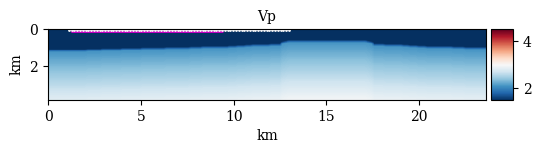

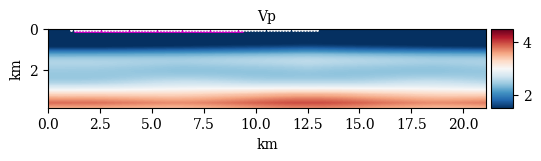

In [13]:
# Set custom wavelet
wls = bpw[:, ::2]
src.wavelets = wavefield_amp_ratio * wls[:, :limit_nt]

vis.plot_acquisition(vp, dx, src, rec, title='Vp',**{'vmax': 4.5, 'vmin': 1.5})
vis.plot_acquisition(vp_cgg_tomo_long, dx, src, rec, title='Vp',**{'vmax': 4.5, 'vmin': 1.5})
print(vp.shape)
print(vp_cgg_tomo_long.shape)
print(model)

In [14]:
wb_taper = np.where(vp < 1.01 * vp.min(), 1, 0)

Save /home/plotnips/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/vinit.png


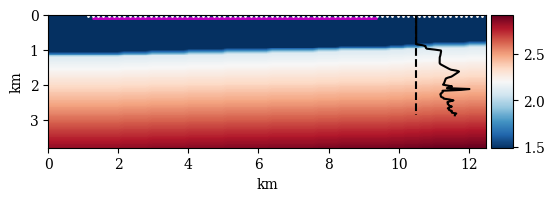

In [15]:
# log = model.vp[:, log_idx]
log = model.vp[-len(wlog):, log_idx]
# model_log = copy.deepcopy(model)

log_dict = {'data':wlog, 'loc': log_loc}
vis.plot_acquisition(vp[:, :500], dx, src, rec, log=log_dict)
vis.savefig('vinit.png')

In [16]:
print(wb_taper.shape)

(152, 944)


Create new initial (orange line). This is to see whether knowledge about exact waterbottom will improve results

(152, 944)
Well-log from 10500 maps into ix: 420


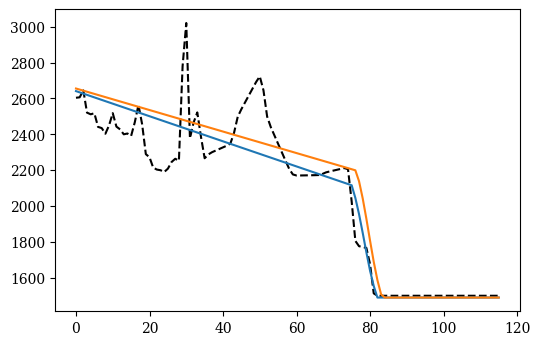

In [17]:
new_vp = np.zeros_like(model.vp)
vps=[]
for i in range(wb_taper.shape[-1]):
    wb = wb_taper.shape[0] - np.argmax(wb_taper[:,i]) + 2
    fun = vmin * np.ones_like(new_vp[:, 0:1])
    fun[wb:, :] = 690 + fun[wb:, :] + 6 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun = fun[::-1, :]
    vps.append(fun)
new_vp = np.concatenate(vps, -1)
new_vp = gaussian_filter(new_vp.copy(), **sigma_truncate)

print(new_vp.shape)
print(f'Well-log from {log_loc} maps into ix: {log_idx}')
plt.figure(); plt.plot(wlog, 'k--'); plt.plot(log[-len(wlog):]); plt.plot(new_vp[-len(wlog):, log_idx])

Set new model as initial

In [18]:
vp = new_vp.copy()
vs = vp.copy() / (3 ** 0.5)
rho = 1e3*0.3 * vp.copy()**0.25

vp = np.where(wb_taper, np.min(vp_cgg), vp)
vs = np.where(wb_taper, 0, vs)
rho = np.where(wb_taper, 1000, rho)

# log = vplog.copy()
model = api.Model(vp, vs, rho, dx)

In [19]:
print(src, end='\n\n------------\n')
print(rec)

name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets	(80, 3000):	min: -400.8610078720592	max: 484.6122728113698
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0

------------
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


## Generate true waveforms

Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [20]:
# Elastic modeling
d.verbose = 1
d.PHYSICS = 1
d.SEISMO = 2
d.DT = dDT
d.NT = data_p.shape[-1]
d.TIME = dDT * d.NT
#
d.FC_SPIKE_2 = 10
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)

# d.TESTSHOT_START = np.round(0.1 * len(src))
# d.TESTSHOT_END = np.round(0.9 * len(src))
# d.TESTSHOT_INCR = 5

d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10

d.QUELLTYPB = 4
d.QUELLART = 3  

d.WRITE_STF = 0

# Acoustic case 
# d.PHYSICS = 2
# src.wavelets = -wls[:, :limit_nt]

print(d.DT, d.NT)

0.002 3000


### Run forward modeling

In [21]:
d.NPROCX = 1
d.NPROCY = 1
par_forward = {'run_command': 'mpirun -np 30', 'disable': True}

In [22]:
d.forward(model, src, rec, **par_forward)

Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./out_for_pasha/
Init model:
	152 x 944, dx = 25.0 m
Check max source frequency:
	min Vs: 931.1580816910116 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 10.093854544076006 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 944 % 1 = 0
	in Y-direction, NY % NPROCY, 152 % 1 = 0
Write ./out_for_pasha/start/model.vp
Write ./out_for_pasha/start/model.vs
Write ./out_for_pasha/start/model.rho
Enable streamer mode!
	source 1: ./out_for_pasha/receiver/receivers_shot_1
	source 2: ./out_for_pasha/receiver/receivers_shot_2
	source 3: ./out_for_pasha/receiver/receivers_shot_3
	source 4: ./out_for_pasha/receiver/receivers_shot_4
	source 5: ./out_for_pasha/receiver/receivers_shot_5
	source 6: ./out_for_pasha/receiver/receivers_shot_6
	source 7: ./out_for_pasha/receiver/receivers_shot_7

	wavelet 59: ./out_for_pasha/wavelet/wavelet_shot_59.dat
	wavelet 60: ./out_for_pasha/wavelet/wavelet_shot_60.dat
	wavelet 61: ./out_for_pasha/wavelet/wavelet_shot_61.dat
	wavelet 62: ./out_for_pasha/wavelet/wavelet_shot_62.dat
	wavelet 63: ./out_for_pasha/wavelet/wavelet_shot_63.dat
	wavelet 64: ./out_for_pasha/wavelet/wavelet_shot_64.dat
	wavelet 65: ./out_for_pasha/wavelet/wavelet_shot_65.dat
	wavelet 66: ./out_for_pasha/wavelet/wavelet_shot_66.dat
	wavelet 67: ./out_for_pasha/wavelet/wavelet_shot_67.dat
	wavelet 68: ./out_for_pasha/wavelet/wavelet_shot_68.dat
	wavelet 69: ./out_for_pasha/wavelet/wavelet_shot_69.dat
	wavelet 70: ./out_for_pasha/wavelet/wavelet_shot_70.dat
	wavelet 71: ./out_for_pasha/wavelet/wavelet_shot_71.dat
	wavelet 72: ./out_for_pasha/wavelet/wavelet_shot_72.dat
	wavelet 73: ./out_for_pasha/wavelet/wavelet_shot_73.dat
	wavelet 74: ./out_for_pasha/wavelet/wavelet_shot_74.dat
	wavelet 75: ./out_for_pasha/wavelet/wavelet_shot_75.dat
	wavelet 76: ./out_for_pasha/wa

In [23]:
# d.save_folder = root_fwi

./out_for_pasha/su/seis
Read 80 shots (324, 3000) into list


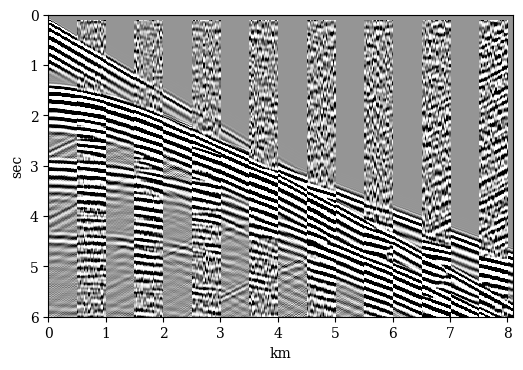

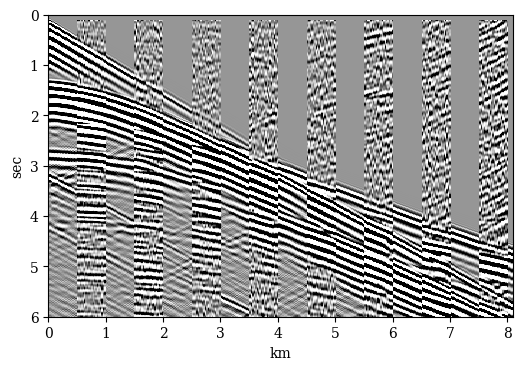

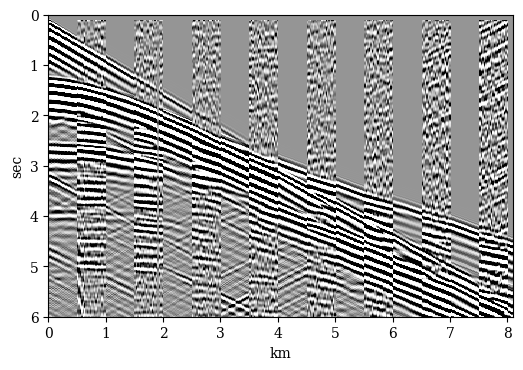

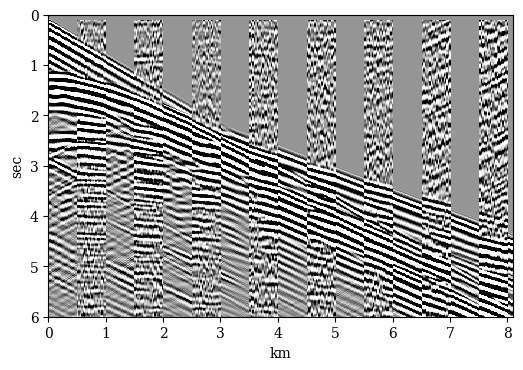

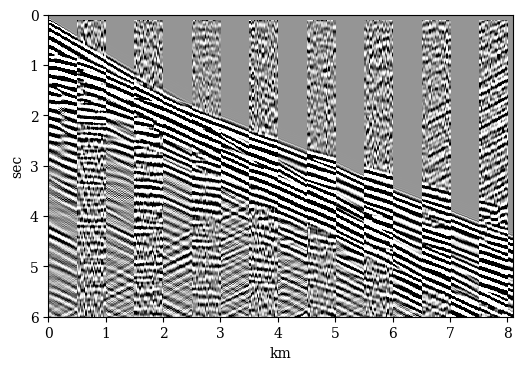

In [24]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
print(d.DATA_DIR)
shots = d.get_shots(keys=['_p.'])

mpl.rcParams['figure.dpi']= 100
par_shot = {'vmin': -0.05, 'vmax': 0.05}
if shots:
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    for i in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 5)]:
        try:
            shot_s = shots[i]
            shot_f = data_p[i, :, ::d.NDT]
            vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx)
        except:
            print(f'Failed to fetch data for i={i}')
mpl.rcParams['figure.dpi']= 100

In [25]:
# wavefield_amp_ratio
print(np.max(np.abs(shot_f)) / np.max(np.abs(shot_s)) )

1.0000142123411118


# Compare syn and field

(80, 324, 3000)
80
Total sources: 80
Syn wavelets:	(80, 500)	-19284.29	26554.20
Field wavelets:	(80, 500)	-16728.73	24865.97
[0, 8, 17, 26, 35, 43, 52, 61, 70, 79]


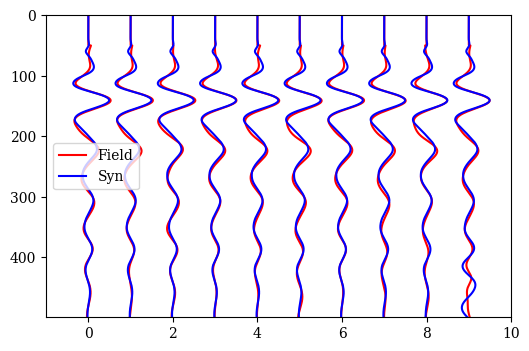

In [26]:
wavelets_s = []
wavelets_f = []
print(data_p.shape)
print(len(shots))
for i, shot in enumerate(shots):
    no, nt = 1, 500
    wavelets_s.append(shot[:no, :nt].copy())
    wavelets_f.append(data_p[i, :no, :nt:d.NDT].copy())
print(f'Total sources: {len(wavelets_f)}')
wavelets_s = np.concatenate(wavelets_s, 0)
wavelets_f = np.concatenate(wavelets_f, 0)

# !!! DO THIS IN FIELD DATA APPLICATION !!!
# THIS MAKES SYNTHETIC AND FIELD COMPARABLE
# OTHERWISE THERE IS INSANE AMPLITUDE MISMATCH
# wavelets_f /= np.max(wavelets_f)
# wavelets_f *= wavelets_s.max()

print('Syn wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_s.shape, wavelets_s.min(), wavelets_s.max()))
print('Field wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_f.shape, wavelets_f.min(), wavelets_f.max()))

vis.plot_wiggles([wavelets_f, wavelets_s], n=10, colors=['r', 'b'], legend=['Field', 'Syn'])

Save /home/plotnips/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/wavelet_syn_field.png


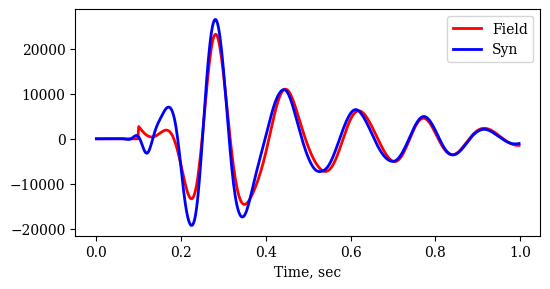

In [27]:
if shots:
    tvec = np.arange(nt) * d.DT
    plt.figure(figsize=(6,3)); 
    trace_idx = 0
    plt.plot(tvec, wavelets_f[trace_idx,:], 'r', lw=2, label='Field')
    plt.plot(tvec, wavelets_s[trace_idx,:], 'b', lw=2, label='Syn')
    # plt.plot(tvec, _dplotted[0][0], 'r', lw=2, label='Field')
    # plt.plot(tvec, _dplotted[1][0], 'b', lw=2, label='Syn')
    plt.legend()
    plt.xlabel('Time, sec')
    vis.savefig('wavelet_syn_field.png')

# REPLACE FIELD DATA BY MARM DATA

In [28]:
# data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
# print(data_p.shape)

In [29]:
data_p_backup = data_p.copy()
print(data_p_backup.shape, d.DT)

(80, 324, 3000) 0.002


Geometric spreading correction (not used)

In [30]:
geom = np.repeat(np.repeat(np.arange(1, data_p.shape[-1]+1)[np.newaxis, ...] * d.DT, data_p.shape[1], 0)[np.newaxis, ...], data_p.shape[0], 0) ** 0.5

# Overwrite by ones, so it is not used
geom = np.ones_like(geom)
data_p = data_p_backup * geom
# data_p = data_p_backup

(80, 324, 3000) -36872.38619092324 29173.327396346955


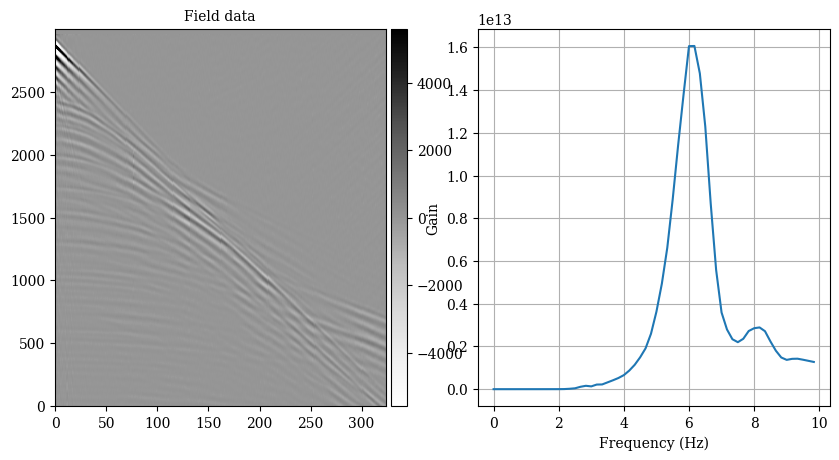

In [31]:
# data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
print(data_p.shape, data_p.min(), data_p.max())
dref = np.mean(data_p, 0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vis.plot_shot(dref, title='Field data', pclip=0.25, colorbar=True, ax=ax[0])
vis.plot_spectrum(dref, dt=0.002, fmax=10, title='Spectrum', ax=ax[1])

## Save field data to a new folder in /su/

In [32]:
def copy_su_from_to(path_from, path_to):
    """ Copy files matching *.su.* from one folder to another folder"""
    os.makedirs(path_to, exist_ok=True)
    su_files = glob.glob(path_from + '/*.su.*')
    su_files = [f for f in su_files if '.it' not in f]
    print(f'Found {len(su_files)} *.su.* files in {path_from}')

    commands = []
    print(f'Copy files from {path_from} to {path_to}')
    for f in su_files:
        commands.append(f'cp {f} {path_to}')
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

In [33]:
root_su_field = os.path.join(d._root_su, 'field/')
copy_su_from_to(d._root_su, root_su_field)

Found 80 *.su.* files in ./out_for_pasha/su
Copy files from ./out_for_pasha/su to ./out_for_pasha/su/field/


In [34]:
def get_fnames_pattern(pattern):    
    fnames = natsorted(glob.glob(pattern))
    fnames = [f for f in fnames if '.it' not in f]
    print(f'{len(fnames)} files found in {pattern}')
    return fnames
fnames = get_fnames_pattern(root_su_field + '*.su.*')

80 files found in ./out_for_pasha/su/field/*.su.*


# Write field data into created .su files

In [35]:
print(data_p.shape, geom.shape)
geom_slice = geom[0, ...]

(80, 324, 3000) (80, 324, 3000)


In [36]:
for i, f in enumerate(fnames):
    with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
        tmp = data_p[i, :, ::d.NDT] / geom_slice[..., ::d.NDT]
        dst.trace = tmp
        print(f, dst.tracecount, tmp.shape, end='\r')

./out_for_pasha/su/field/seis_p.su.shot1 324 (324, 3000)
./out_for_pasha/su/field/seis_p.su.shot2 324 (324, 3000)
./out_for_pasha/su/field/seis_p.su.shot3 324 (324, 3000)
./out_for_pasha/su/field/seis_p.su.shot4 324 (324, 3000)
./out_for_pasha/su/field/seis_p.su.shot5 324 (324, 3000)


/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env/lib/python3.6/site-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


# Copy field data to folder with FWI for CNN and apply high-pass filter above 5 Hz

In [37]:
from F_utils import *
from F_fwi import *
results_path='./out_for_pasha/cnn'
denise_root = '../'
# denise_root = './out_for_pasha/cnn/fld'
d = api.Denise(denise_root, verbose=1)
d.INV_MOD_OUT=1
d.save_folder=os.path.join(results_path,'fld','');      print(d.save_folder)
d.set_paths(makedirs=True)

Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise
Parse ../par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/
./out_for_pasha/cnn/fld/
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./out_for_pasha/cnn/fld/


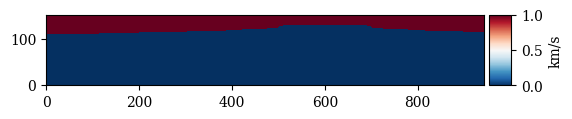

In [38]:
wb_taper = np.where(model.vp < 1.01 * model.vp.min(), 1, 0)
vis.plot_model(wb_taper)

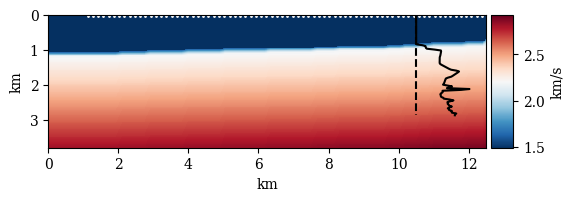

In [39]:
nx0 = 500
limits_vp = {'vmin': model.vp.min() / 1000, 'vmax': model.vp.max() / 1000}
vis.plot_log_model(model.vp, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)
mpl.rcParams['figure.dpi']= 100

### Abstraction over initial model

In [40]:
model_init = copy.copy(model)
print(model_init)

vp:	(152, 944), 1490.0000, 2929.2909 m/s

vs:	(152, 944), 0.0000, 1691.2269 m/s

rho:	(152, 944), 1000.0000, 2207.0485 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


(116, 1) (152, 944)


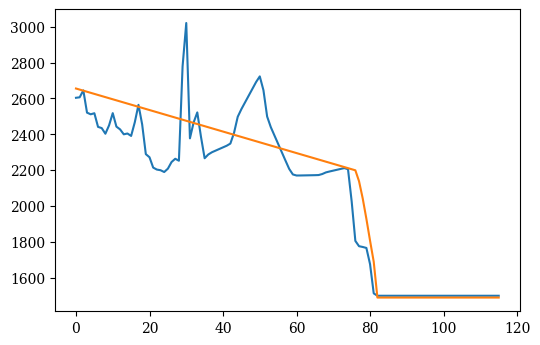

In [41]:
print(wlog.shape, vp.shape)
fig, ax = plt.subplots(1,1)
ax.plot(wlog)
ax.plot(vp[-len(wlog):, log_idx])

# Full-waveform inversion
Invert for elastic properties `vp`, `vs` and `rho`, given `x` and `y` velocity components of wavefield 

## Initial velocity model
Smooth background model with true water bottom and shallow sediments

116 (152, 944) 116


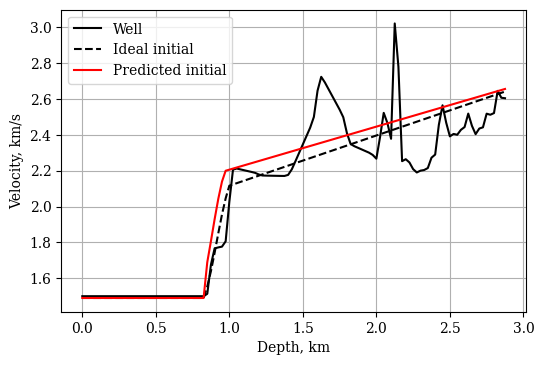

In [42]:
# ax = plot_model(np.concatenate((model_init.vp, model_init.vs, model_init.rho), 1))
# plot_logs(model_log, model_init, log_idx)

fig, ax = plt.subplots(1,1); 
ax_depth = np.arange(len(wlog)) * dx / 1000
# ax_depth = np.arange(len(log_linear)) * dx / 1000
ax.plot(ax_depth, wlog[::-1] / 1000, 'k', label='Well')
ax.plot(ax_depth, log[::-1] / 1000, 'k--', label='Ideal initial')

# log_pred = model_init.vp[-len(wlog):, log_idx]

log_pred = model_init.vp[-len(log):, log_idx]
ax.plot(ax_depth, log_pred[::-1] / 1000, 'r', label='Predicted initial')

nwater = 33#33
dummy = np.zeros_like(model.vp)
dummy[-nwater:, :] = 1.
log_taper = np.min(log_pred) + dummy[:, log_idx] * (np.max(log_pred) - np.min(log_pred))
log_taper = np.min(log_pred) + wb_taper[-len(wlog):, log_idx] * (np.max(log_pred) - np.min(log_pred))
# ax.plot(ax_depth, log_taper[::-1]  / 1000, 'b', label='Taper')
# 
# ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Linear')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

print(len(wlog), model_init.vp.shape, len(model_init.vp[:len(wlog)]))

In [43]:
plot_logs(model_log, model_init, log_idx)

## Stages of inversion
Use default parameters, except high- and low-pass corner frequencies of Butterworth filter

In [44]:
d.PHYSICS=1
d.SEISMO=2
d.QUELLTYPB=4
d.SWS_TAPER_GRAD_HOR = 1
d.GRADT1, d.GRADT2 = 25, 30

(152, 944) (152, 944)
Save (944, 152) as binary to ./out_for_pasha/cnn/fld/taper/taper.bin
Save (944, 152) as binary to ./out_for_pasha/cnn/fld/taper/taper_u.bin
Save (944, 152) as binary to ./out_for_pasha/cnn/fld/taper/taper_rho.bin


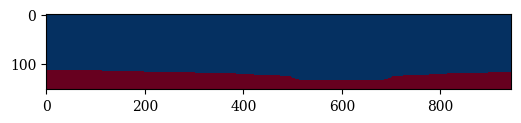

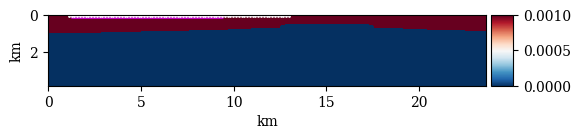

In [45]:
# import loaders as ld
d.VPUPPERLIM = 3000.
d.VPLOWERLIM = np.min(model_init.vp)
d.VSUPPERLIM = 2500.
d.VSLOWERLIM = np.min(model_init.vs)
d.RHOUPPERLIM = 2500.
d.RHOLOWERLIM = np.min(model_init.rho)
d.SWS_TAPER_FILE = 1
taper = np.zeros_like(model_init.vp)
print(taper.shape,wb_taper.shape)
shift = 4
taper[shift:, :] = wb_taper[:-shift,:] # water mask
plt.imshow(taper)
if d.SWS_TAPER_FILE:
    os.makedirs(d._root_tapers, exist_ok=True)
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_u.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_rho.bin'))
    vis.plot_acquisition(taper, dx, src, rec)

## Run inversion

In [46]:
d.fwi_stages=[]
# # full_fwi_strategy
# par_stages_fwi={'inv_vs_iter': 0,              
#                  'inv_rho_iter': 0,
#                  'normalize': 2,
#                  'order': 6,
#                 }
# d.fwi_stages = []
# freqs_high = [3, 4, 5, 6, 7]
# grad_smoothing = [2, 1.5, 0.5, 0.25, 0.125]
# lnorms = [2, 2, 2, 2, 2, 2]
# spatfilters = [4, 4, 0, 0, 0, 0]
# for i, freq in enumerate(freqs_high):
#     d.add_fwi_stage(fc_high=freq, 
#                     wd_damp=grad_smoothing[i],
#                     wd_damp1=grad_smoothing[i],
#                     lnorm=lnorms[i],
#                     spatfilter=spatfilters[i],
#                     **par_stages_fwi)
#     print(f'Stage {i+1}:\n\t{d.fwi_stages[i]}\n')
# cnn_input_fwi_strategy
d.STEPMAX=200
################### gradient step length estimation
##########  testshots for gradient step length estimation,    (TESTSHOT_START,TESTSHOT_END,TESTSHOT_INCR) = 1,17,2
d.TESTSHOT_START=1; d.TESTSHOT_END=len(src._ones);  d.TESTSHOT_INCR=5
d.EPS_SCALE=0.0001
d.SCALEFAC=1.2
################### seismic data bandwidth
TIME_FILT=1
d.ITERMAX=5
################### define fwi stages
########### make strong smoothing on low frequency data. [0,6] hz data
freq=8; wd_damp=0
d.add_fwi_stage(fc_low=0.0,fc_high=freq,time_filt=TIME_FILT,normalize=2,
    e_precond=3,spatfilter=0,pro=1e-2,
    wd_damp=wd_damp,wd_damp1=wd_damp)
freq=10; wd_damp=0
d.add_fwi_stage(fc_low=0.0,fc_high=freq,time_filt=TIME_FILT,normalize=2,
    e_precond=3,spatfilter=0,pro=1e-5,
    wd_damp=wd_damp,wd_damp1=wd_damp)
for i,stage in enumerate(d.fwi_stages):
    print(f'Stage {i+1}:\n\t{stage}\n')

Stage 1:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 8, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 0, 'WD_DAMP': 0, 'WD_DAMP1': 0, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 2, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 2:
	{'PRO': 1e-05, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 10, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 0, 'WD_DAMP': 0, 'WD_DAMP1': 0, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 2, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}



In [47]:
d.DATA_DIR = f'{root_fwi}su/field/seis';    
print(d.DATA_DIR)
print(d.save_folder)
print(os.path.join(d.save_folder,'su'))
d.DATA_DIR =os.path.join(d.save_folder,'su','seis')

./out_for_pasha/su/field/seis
./out_for_pasha/cnn/fld/
./out_for_pasha/cnn/fld/su


In [48]:
# nodes number=10
print(model.vp.shape)
d.WRITE_STF = 0
d.NPROCX = 4
d.NPROCY = 1
d.verbose = 1
par_fwi_runtime = {'run_command': 'mpirun -np 32', 'disable': True}
if d.DT is None:
    d.DT = 0.002
d.filename=os.path.join(d.save_folder,'seis_inversion.inp');    print(d.filename)
d.MFILE=os.path.join(d.save_folder,'start/model')
d.fwi(model_init, src, rec, **par_fwi_runtime)
d.MFILE=os.path.join(d.save_folder,'start/model_init')
d.fwi(model_init, src, rec, **par_fwi_runtime)

(152, 944)
./out_for_pasha/cnn/fld/seis_inversion.inp
Target data: ./out_for_pasha/cnn/fld/su/seis
Create FWI workflow file in ./out_for_pasha/cnn/fld/seis_fwi.inp
Init model:
	152 x 944, dx = 25.0 m
Check max source frequency:
	min Vs: 931.1580816910116 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 10.093854544076006 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 944 % 4 = 0
	in Y-direction, NY % NPROCY, 152 % 1 = 0
Write ./out_for_pasha/cnn/fld/start/model.vp
Write ./out_for_pasha/cnn/fld/start/model.vs
Write ./out_for_pasha/cnn/fld/start/model.rho
Custom taper from taper.bin (vp), taper_u.bin (vs) and taper_rho.bin (rho)
Write sources and receivers in single file each!
Write wavelets, one for every shot.
	wavelet 1: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_1.dat
	wavelet 2: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_2.dat
	wavelet 3: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_

	wavelet 31: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_31.dat
	wavelet 32: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_32.dat
	wavelet 33: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_33.dat
	wavelet 34: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_34.dat
	wavelet 35: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_35.dat
	wavelet 36: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_36.dat
	wavelet 37: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_37.dat
	wavelet 38: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_38.dat
	wavelet 39: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_39.dat
	wavelet 40: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_40.dat
	wavelet 41: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_41.dat
	wavelet 42: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_42.dat
	wavelet 43: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_43.dat
	wavelet 44: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_44.dat
	wavelet 45: ./out_for_pasha/cnn/fld/wavelet/wavelet_shot_45.dat
	wavelet 46: ./out_for_pa

### Visualize FWI outputs
It will not hurt to make sure that paths and model dims are up to date. This is necessary when you only want to plot pictures, without running modeling or FWI

In [49]:
api._cmd('rm -r '+os.path.join(d.save_folder,'su'))
copy_su_from_to('./out_for_pasha/su/field',os.path.join(d.save_folder,'su'))
denise_folder_process('crop_zero_freqs',results_path,denise_root=denise_root)

rm -r ./out_for_pasha/cnn/fld/su
Found 80 *.su.* files in ./out_for_pasha/su/field
Copy files from ./out_for_pasha/su/field to ./out_for_pasha/cnn/fld/su
processing ./out_for_pasha/cnn
Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise
low frequency data corner frequency,  5
Read 80 shots (324, 3000) into list
save to ./out_for_pasha/cnn/pictures/shot_0.png
save to ./out_for_pasha/cnn/pictures/shot0_stage2.png
pic saved to  ./out_for_pasha/cnn/pictures/spectrum_0_original.png
pic saved to  ./out_for_pasha/cnn/pictures/spectrum_0stage2.png


/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env/lib/python3.6/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env/lib/python3.6/site-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


save to ./out_for_pasha/cnn/pictures/shot_22.png
save to ./out_for_pasha/cnn/pictures/shot22_stage2.png
pic saved to  ./out_for_pasha/cnn/pictures/spectrum_22_original.png
pic saved to  ./out_for_pasha/cnn/pictures/spectrum_22stage2.png


/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env/lib/python3.6/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env/lib/python3.6/site-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


save to ./out_for_pasha/cnn/pictures/shot_44.png
save to ./out_for_pasha/cnn/pictures/shot44_stage2.png
pic saved to  ./out_for_pasha/cnn/pictures/spectrum_44_original.png
pic saved to  ./out_for_pasha/cnn/pictures/spectrum_44stage2.png


/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env/lib/python3.6/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env/lib/python3.6/site-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


save to ./out_for_pasha/cnn/pictures/shot_66.png
save to ./out_for_pasha/cnn/pictures/shot66_stage2.png
pic saved to  ./out_for_pasha/cnn/pictures/spectrum_66_original.png
pic saved to  ./out_for_pasha/cnn/pictures/spectrum_66stage2.png


/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env/lib/python3.6/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env/lib/python3.6/site-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


In [50]:
imports = 'import sys,os\n'
imports = imports+f"sys.path.append(os.getcwd())\n"
imports = imports+f"sys.path.append('/lustre/project/k1404/pavel/DENISE-Black-Edition')\n"
imports = imports+'from F_utils import *\n'
imports = imports+'from F_plotting import *\n'
imports = imports+'from F_fwi import *\n'
imports = imports+'import fnmatch\n'
imports = imports+'from glob import glob\n'
imports = imports+'import numpy as np\n'
imports = imports+'import pyapi_denise_pavel as api\n'
post_processing = imports
post_processing = post_processing+f"denise_folder_process('plot','{results_path}')\n"
post_processing = post_processing+f"denise_folder_process('optimizing_space_','{os.path.join(results_path)}')\n"
post_processing = post_processing+f"denise_folder_process('plot','{results_path}')\n"
post_processing_script_name = os.path.join(d.save_folder,'post_processing_script.py')
print(post_processing_script_name)
f = open(post_processing_script_name, 'w')
f.write(post_processing)
f.close()

./out_for_pasha/cnn/fld/post_processing_script.py


### Inverted model
The code ouputs inverted models for every elastic property at every FWI stage. Change `vp` to `vs` or `rho` to explore respective outputs

In [51]:
# d.set_model(model_init)
# print(d.save_folder)
mpl.rcParams['figure.dpi']= 300
d.verbose = 2

models, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
for m, f in zip(models, fnames):
    vis.plot_log_model(m, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)
mpl.rcParams['figure.dpi']= 100

Parse files from ./out_for_pasha/cnn/fld/model which contain ['vp', 'stage']
No files found! Exception raised.


### Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

In [52]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    plot_logs(model_log, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

Parse files from ./out_for_pasha/cnn/fld/model which contain ['vp_stage']
No files found! Exception raised.
Parse files from ./out_for_pasha/cnn/fld/model which contain ['vs_stage']
No files found! Exception raised.
Parse files from ./out_for_pasha/cnn/fld/model which contain ['rho_stage']
No files found! Exception raised.


### Gradients

In [53]:
d.verbose = 0
grads, fnames = d.get_fwi_gradients(return_filenames=True)
for g, f in zip(grads, fnames):
    plot_model(g, f)

In [54]:
# d.help()

In [55]:
def get_model_last():
    all_fnames = []
    # vps, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
    vps, fnames = d.get_fwi_models(['vp'], return_filenames=True)
    all_fnames += fnames
    vss, fnames = d.get_fwi_models(['vs'], return_filenames=True)
    all_fnames += fnames
    rhos, fnames = d.get_fwi_models(['rho'], return_filenames=True)
    all_fnames += fnames
    print(all_fnames)
    if all_fnames:
        for f in all_fnames:
            if not f.split('/')[-1] in os.listdir(f'{root_fwi}start/'):
                command = f'cp {f} {root_fwi}start/'
                print(command)
                os.system(command)
    if vps:
        print(f'Init new starting model from {fnames[-1]}')
        model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    # print(vps)
    return model_last
    # return None
model_last=get_model_last()

[]


UnboundLocalError: local variable 'model_last' referenced before assignment

In [ ]:
vis.plot_model(model_last.vp / 1000, **limits_vp)

# Compare wavefiedls before/after

In [ ]:
vps, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
vss, fnames = d.get_fwi_models(['vs_stage'], return_filenames=True)
rhos, fnames = d.get_fwi_models(['rho_stage'], return_filenames=True)
print(d.save_folder)
if vps:
    model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    print(f'Found last model at {fnames[-1]}')
else:
    print(f'Not found the inverted model in {d.save_folder}!')

In [ ]:
d.save_folder = root_fwi[:-1] + '_wavefield/'
print(f'{root_fwi[:-1]} --> {d.save_folder}')

In [ ]:
print(par_forward)

In [ ]:
d.NPROCX = 1
d.NPROCY = 1
d.forward(model_last, src, rec, **par_forward)

In [ ]:
# print(d.stdout)

In [ ]:
print(src.x[19], src.x[62])

In [ ]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]
print(f'Read {len(shots)} shots {shots[0].shape} into list')

mpl.rcParams['figure.dpi']= 300
# for ishot in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 5)]:
for ishot in [19, 62]:
    print(ishot)
    shot_s = divmax(shots[ishot])
    shot_f = divmax(data_p[ishot, :, ::d.NDT])
#     vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.05)
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx)
mpl.rcParams['figure.dpi']= 100